#  Predicting UTI Risk During Pregnancy: A Ghana-Based Analysis

This notebook presents a full data science workflow applied to a primary healthcare dataset collected from pregnant women in Ghana. The project investigates urinary tract infections (UTIs) — a common and potentially serious condition during pregnancy — by analyzing symptoms, demographic factors, and health-seeking behavior.

The dataset contains responses related to maternal age, trimester, education, malaria history, and UTI-specific symptoms such as dysuria and frequent urination. While the original data collector remains unknown, full acknowledgment is extended to the individuals or institutions involved in gathering this essential health data.

The notebook is structured in two main phases:
1. **Exploratory Data Analysis (EDA)** — uncovering key insights and visualizing patterns across symptoms, demographics, and UTI outcomes.
2. **Predictive Modeling** — applying machine learning algorithms to build a classifier that predicts UTI risk using patient-level features.

This work aims to inform public health awareness while also showcasing practical machine learning applications in healthcare analytics.


# Loading Important Libraries

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [2]:
df_pregnancy = pd.read_excel(r"C:\Users\attafuro\Desktop\Ahmed;s Project\biodata.xlsx")

# Data Exploration and Cleaning

In [4]:
# Basic Exploration
df_pregnancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 31 columns):
 #   Column                                                                                                               Non-Null Count  Dtype 
---  ------                                                                                                               --------------  ----- 
 0   CODE                                                                                                                 241 non-null    int64 
 1   1. Age                                                                                                               241 non-null    object
 2   2. Level of education                                                                                                238 non-null    object
 3   3. Ethnic group                                                                                                      241 non-null    object
 4   4. Marital status   

In [5]:
df_pregnancy.head()

,CODE,1. Age,2. Level of education,3. Ethnic group,4. Marital status,5. Employment status,6. Occupation,7. Place of residence,8. Religion,9. Trimester,...,21. Have you taken anti-malaria medicine(treatment) for malaria during your pregnancy?,Cough,Chills,Headache,Nasal congestion or running nose,Frequent urination,Dysuria(pain during urination),24. Have you been tested for urinary tract infection (UTI) during this pregnancy?,"25. If tested for UTI, what were the results?",26. Have you taken antibiotic within the past one week
0,211,42,Primary,Others,Married,Unemployed,Farming,Kodie,Christianity,2,...,No,Yes,Yes,No,Yes,Yes,No,No,NaN,No
1,238,45,JHS,Ethnic group in Northern Ghana,Married,Unemployed,Trading,Suame,Christianity,3,...,No,No,Yes,Yes,No,Yes,No,No,NaN,No
2,193,17,JHS,Ga,Single,Unemployed,Others,Maakro,Christianity,1,...,No,No,No,Yes,Yes,No,No,No,NaN,No
3,173,32,JHS,Ga,Married,Employed,Farming,Bremang UGC,Christianity,2,...,No,Yes,Yes,Yes,Yes,Yes,Yes,No,NaN,No
4,166,36,JHS,Akan,Married,Unemployed,Others,Bremang,Christianity,3,...,No,No,Yes,Yes,No,Yes,Yes,No,NaN,No


In [6]:
df_pregnancy.columns = [
    "CODE", "Age", "Education", "EthnicGroup", "MaritalStatus", "EmploymentStatus",
    "Occupation", "Residence", "Religion", "Trimester", "PrevDeliveries",
    "MosquitoNet", "WhyNoNet", "FeverPastWeek", "FeverFreq", "MedicalAttention",
    "IPTpTreatment", "IPTpDoses", "WhyNoIPTp", "MalariaTested", "MalariaResult",
    "AntimalarialTaken", "Cough", "Chills", "Headache", "NasalCongestion",
    "FrequentUrination", "Dysuria", "UTITest", "UTIResult", "AntibioticPastWeek"
]

In [8]:
df_pregnancy.head()

,CODE,Age,Education,EthnicGroup,MaritalStatus,EmploymentStatus,Occupation,Residence,Religion,Trimester,...,AntimalarialTaken,Cough,Chills,Headache,NasalCongestion,FrequentUrination,Dysuria,UTITest,UTIResult,AntibioticPastWeek
0,211,42,Primary,Others,Married,Unemployed,Farming,Kodie,Christianity,2,...,No,Yes,Yes,No,Yes,Yes,No,No,NaN,No
1,238,45,JHS,Ethnic group in Northern Ghana,Married,Unemployed,Trading,Suame,Christianity,3,...,No,No,Yes,Yes,No,Yes,No,No,NaN,No
2,193,17,JHS,Ga,Single,Unemployed,Others,Maakro,Christianity,1,...,No,No,No,Yes,Yes,No,No,No,NaN,No
3,173,32,JHS,Ga,Married,Employed,Farming,Bremang UGC,Christianity,2,...,No,Yes,Yes,Yes,Yes,Yes,Yes,No,NaN,No
4,166,36,JHS,Akan,Married,Unemployed,Others,Bremang,Christianity,3,...,No,No,Yes,Yes,No,Yes,Yes,No,NaN,No


In [12]:
df_pregnancy.isna().sum()

CODE                    0
Age                     0
Education               3
EthnicGroup             0
MaritalStatus           0
EmploymentStatus        0
Occupation              0
Residence               0
Religion                0
Trimester               0
PrevDeliveries          0
MosquitoNet             0
WhyNoNet               86
FeverPastWeek           0
FeverFreq               0
MedicalAttention        0
IPTpTreatment           0
IPTpDoses               0
WhyNoIPTp             102
MalariaTested           0
MalariaResult          71
AntimalarialTaken       0
Cough                   0
Chills                  0
Headache                0
NasalCongestion         0
FrequentUrination       0
Dysuria                 0
UTITest                 0
UTIResult              80
AntibioticPastWeek      0
dtype: int64

In [9]:
# View all column data types
print(df_pregnancy.dtypes)

CODE                   int64
Age                   object
Education             object
EthnicGroup           object
MaritalStatus         object
EmploymentStatus      object
Occupation            object
Residence             object
Religion              object
Trimester              int64
PrevDeliveries         int64
MosquitoNet           object
WhyNoNet              object
FeverPastWeek         object
FeverFreq             object
MedicalAttention      object
IPTpTreatment         object
IPTpDoses              int64
WhyNoIPTp             object
MalariaTested         object
MalariaResult         object
AntimalarialTaken     object
Cough                 object
Chills                object
Headache              object
NasalCongestion       object
FrequentUrination     object
Dysuria               object
UTITest               object
UTIResult             object
AntibioticPastWeek    object
dtype: object


In [15]:
# WhyNoNet: Only fill "Unknown" if MosquitoNet is 'No' AND WhyNoNet is missing
df_pregnancy.loc[(df_pregnancy['MosquitoNet'] == 'No') & (df_pregnancy['WhyNoNet'].isna()), 'WhyNoNet'] = 'Unknown'

# Fill "Not Applicable" where MosquitoNet is 'Yes'
df_pregnancy.loc[(df_pregnancy['MosquitoNet'] == 'Yes') & (df_pregnancy['WhyNoNet'].isna()), 'WhyNoNet'] = 'Not Applicable'

In [18]:
df_pregnancy.loc[
    (df_pregnancy['IPTpTreatment'] == 'No') & (df_pregnancy['WhyNoIPTp'].isna()),
    'WhyNoIPTp'] = 'Unknown'

df_pregnancy.loc[
    (df_pregnancy['IPTpTreatment'] == 'Yes') & (df_pregnancy['WhyNoIPTp'].isna()),
    'WhyNoIPTp'] = 'Not Applicable'

In [19]:
df_pregnancy.loc[
    (df_pregnancy['MalariaTested'] == 'Yes') & (df_pregnancy['MalariaResult'].isna()),
    'MalariaResult'
] = 'Unknown'

df_pregnancy.loc[
    (df_pregnancy['MalariaTested'] == 'No') & (df_pregnancy['MalariaResult'].isna()),
    'MalariaResult'
] = 'Not Applicable'

In [20]:
# Fill "Unknown" if the person was tested for UTI but the result is missing
df_pregnancy.loc[
    (df_pregnancy['UTITest'] == 'Yes') & (df_pregnancy['UTIResult'].isna()),
    'UTIResult'
] = 'Unknown'

# Fill "Not Applicable" if the person was not tested and result is missing
df_pregnancy.loc[
    (df_pregnancy['UTITest'] == 'No') & (df_pregnancy['UTIResult'].isna()),
    'UTIResult'
] = 'Not Applicable'


In [23]:
# Fill missing values in Education with the most frequent category (mode)
df_pregnancy['Education'] = df_pregnancy['Education'].fillna(df_pregnancy['Education'].mode()[0])

In [24]:
df_pregnancy.isna().sum()

CODE                  0
Age                   0
Education             0
EthnicGroup           0
MaritalStatus         0
EmploymentStatus      0
Occupation            0
Residence             0
Religion              0
Trimester             0
PrevDeliveries        0
MosquitoNet           0
WhyNoNet              0
FeverPastWeek         0
FeverFreq             0
MedicalAttention      0
IPTpTreatment         0
IPTpDoses             0
WhyNoIPTp             0
MalariaTested         0
MalariaResult         0
AntimalarialTaken     0
Cough                 0
Chills                0
Headache              0
NasalCongestion       0
FrequentUrination     0
Dysuria               0
UTITest               0
UTIResult             0
AntibioticPastWeek    0
dtype: int64

In [25]:
df_pregnancy['Age'] = pd.to_numeric(df_pregnancy['Age'], errors='coerce').astype('Int64')

In [26]:
categorical_cols = [
    # Demographics
    'Education', 'EthnicGroup', 'MaritalStatus', 'EmploymentStatus',
    'Occupation', 'Residence', 'Religion',

    # Pregnancy-related decisions & responses
    'MosquitoNet', 'WhyNoNet', 'FeverPastWeek', 'FeverFreq',
    'MedicalAttention', 'IPTpTreatment', 'WhyNoIPTp',
    'MalariaTested', 'MalariaResult', 'AntimalarialTaken',
    'UTITest', 'UTIResult', 'AntibioticPastWeek',

    # Symptoms (binary)
    'Cough', 'Chills', 'Headache', 'NasalCongestion',
    'FrequentUrination', 'Dysuria'
]

df_pregnancy[categorical_cols] = df_pregnancy[categorical_cols].astype('category')

In [30]:
df_pregnancy.drop(columns='CODE', inplace=True)

In [31]:
df_pregnancy.dtypes

Age                      Int64
Education             category
EthnicGroup           category
MaritalStatus         category
EmploymentStatus      category
Occupation            category
Residence             category
Religion              category
Trimester                int64
PrevDeliveries           int64
MosquitoNet           category
WhyNoNet              category
FeverPastWeek         category
FeverFreq             category
MedicalAttention      category
IPTpTreatment         category
IPTpDoses                int64
WhyNoIPTp             category
MalariaTested         category
MalariaResult         category
AntimalarialTaken     category
Cough                 category
Chills                category
Headache              category
NasalCongestion       category
FrequentUrination     category
Dysuria               category
UTITest               category
UTIResult             category
AntibioticPastWeek    category
dtype: object

In [32]:
df_pregnancy.describe()

,Age,Trimester,PrevDeliveries,IPTpDoses
count,240.0,241.000000,241.000000,241.000000
mean,29.345833,2.203320,1.522822,0.917012
std,7.683677,0.819139,1.535855,1.288313
min,17.0,1.000000,0.000000,0.000000
25%,24.0,2.000000,0.000000,0.000000
50%,29.0,2.000000,1.000000,0.000000
75%,34.25,3.000000,2.000000,2.000000
max,51.0,4.000000,7.000000,5.000000


In [33]:
df_pregnancy.describe(include='category')

,Education,EthnicGroup,MaritalStatus,EmploymentStatus,Occupation,Residence,Religion,MosquitoNet,WhyNoNet,FeverPastWeek,...,AntimalarialTaken,Cough,Chills,Headache,NasalCongestion,FrequentUrination,Dysuria,UTITest,UTIResult,AntibioticPastWeek
count,241,241,241,241,241,241,241,241,241,241,...,241,241,241,241,241,241,241,241,241,241
unique,4,5,4,2,4,67,3,2,53,1,...,3,3,3,3,3,3,3,3,4,2
top,SHS,Akan,Married,Employed,Others,Kronum,Christianity,No,Not Applicable,Yes,...,No,No,No,Yes,No,Yes,No,Yes,Negative for UTI,No
freq,105,144,141,162,117,26,196,155,86,241,...,144,159,142,158,164,164,188,124,90,222


In [35]:
print("UTI Result Distribution:")
print(df_pregnancy['UTIResult'].value_counts())

UTI Result Distribution:
UTIResult
Negative for UTI     90
Not Applicable       80
Not sure             38
Positive for  UTI    33
Name: count, dtype: int64


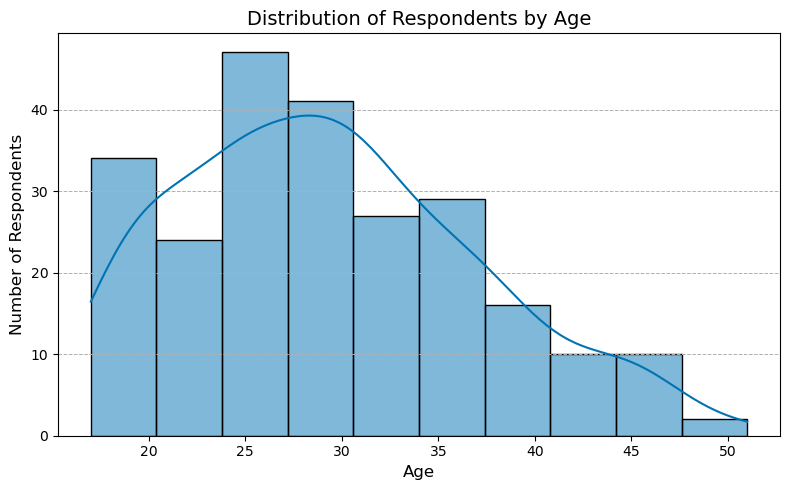

In [46]:
colors = sns.color_palette("colorblind")

plt.figure(figsize=(8, 5))
sns.histplot(df_pregnancy['Age'], bins=10, kde=True, color=colors[0])
plt.title("Distribution of Respondents by Age", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Number of Respondents", fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

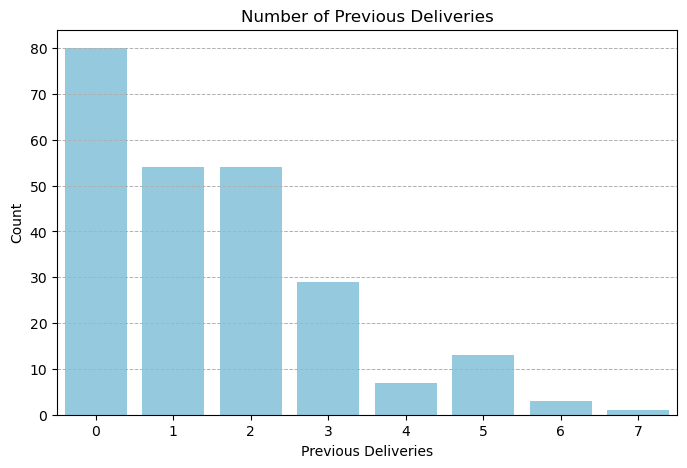

In [39]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_pregnancy, x='PrevDeliveries', color='skyblue')
plt.title('Number of Previous Deliveries')
plt.xlabel('Previous Deliveries')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

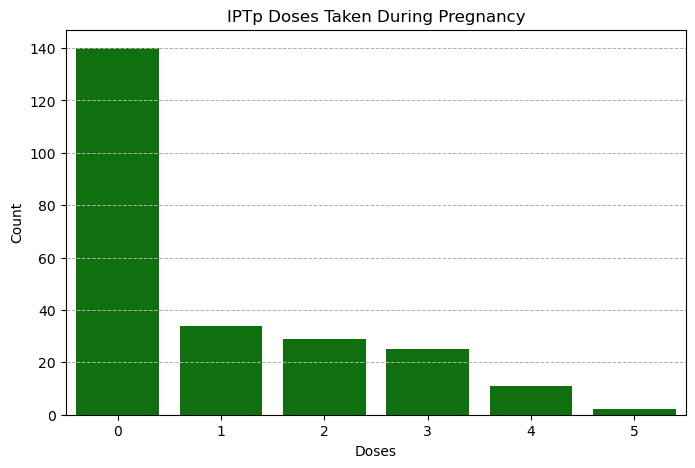

In [43]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_pregnancy, x='IPTpDoses', color='green')
plt.title('IPTp Doses Taken During Pregnancy')
plt.xlabel('Doses')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

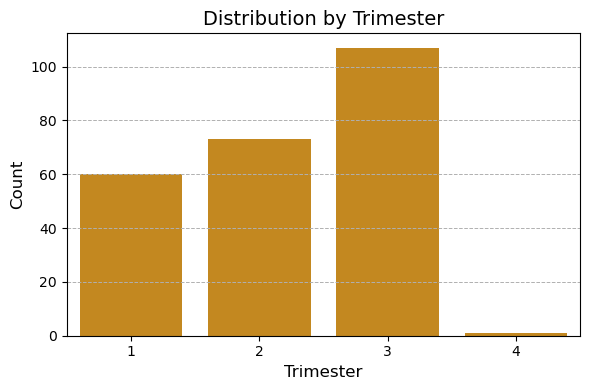

In [47]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df_pregnancy, x='Trimester', color=colors[1])
plt.title("Distribution by Trimester", fontsize=14)
plt.xlabel("Trimester", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

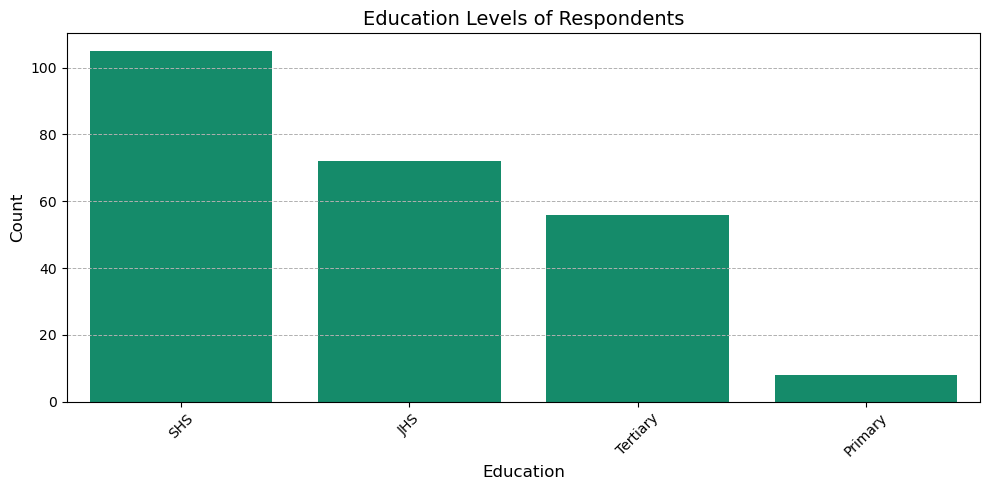

In [48]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_pregnancy, x='Education', order=df_pregnancy['Education'].value_counts().index, color=colors[2])
plt.title("Education Levels of Respondents", fontsize=14)
plt.xlabel("Education", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

In [52]:
# Remove leading/trailing spaces and fix inconsistent spacing
df_pregnancy['UTIResult'] = df_pregnancy['UTIResult'].str.strip().replace({
    'Positive for  UTI': 'Positive',
    'Negative for UTI': 'Negative',
    'Not sure': 'Unknown',
    'Not Applicable': 'Not Applicable'
})

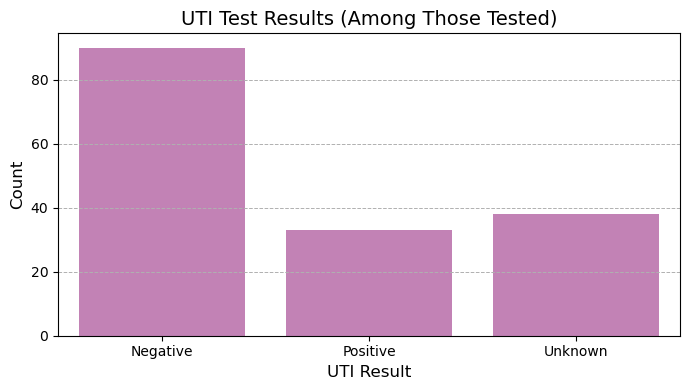

In [53]:
# Filter properly now
df_tested = df_pregnancy[df_pregnancy['UTIResult'] != 'Not Applicable']

# Plot
plt.figure(figsize=(7, 4))
sns.countplot(data=df_tested, x='UTIResult', order=['Negative', 'Positive', 'Unknown'], color=sns.color_palette("colorblind")[4])
plt.title("UTI Test Results (Among Those Tested)", fontsize=14)
plt.xlabel("UTI Result", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

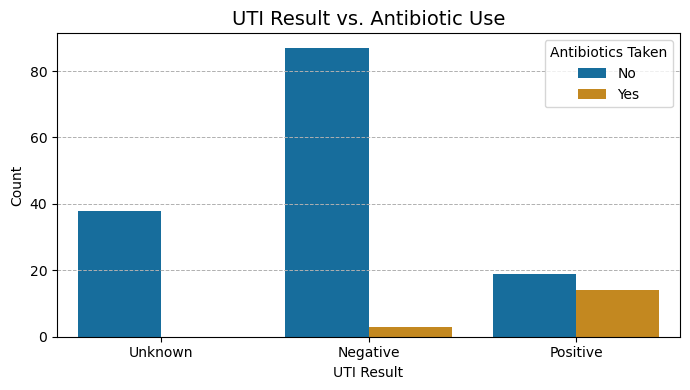

In [54]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df_tested, x='UTIResult', hue='AntibioticPastWeek', palette='colorblind')
plt.title("UTI Result vs. Antibiotic Use", fontsize=14)
plt.xlabel("UTI Result")
plt.ylabel("Count")
plt.legend(title='Antibiotics Taken')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

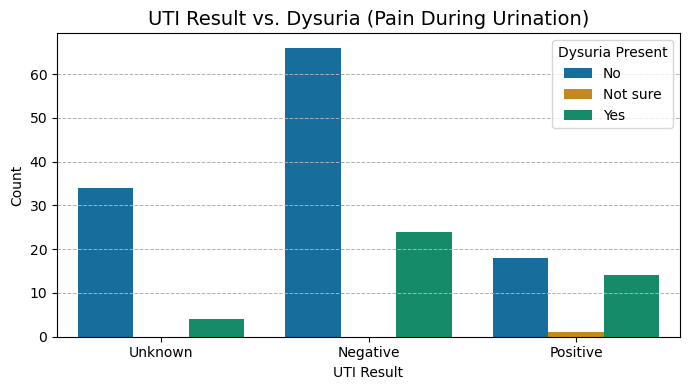

In [55]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df_tested, x='UTIResult', hue='Dysuria', palette='colorblind')
plt.title("UTI Result vs. Dysuria (Pain During Urination)", fontsize=14)
plt.xlabel("UTI Result")
plt.ylabel("Count")
plt.legend(title='Dysuria Present')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

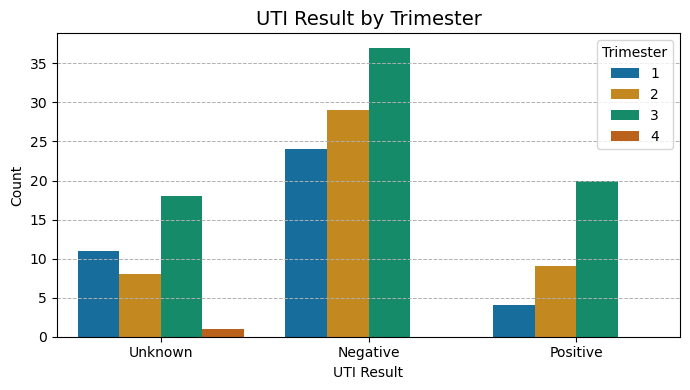

In [56]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df_tested, x='UTIResult', hue='Trimester', palette='colorblind')
plt.title("UTI Result by Trimester", fontsize=14)
plt.xlabel("UTI Result")
plt.ylabel("Count")
plt.legend(title='Trimester')
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

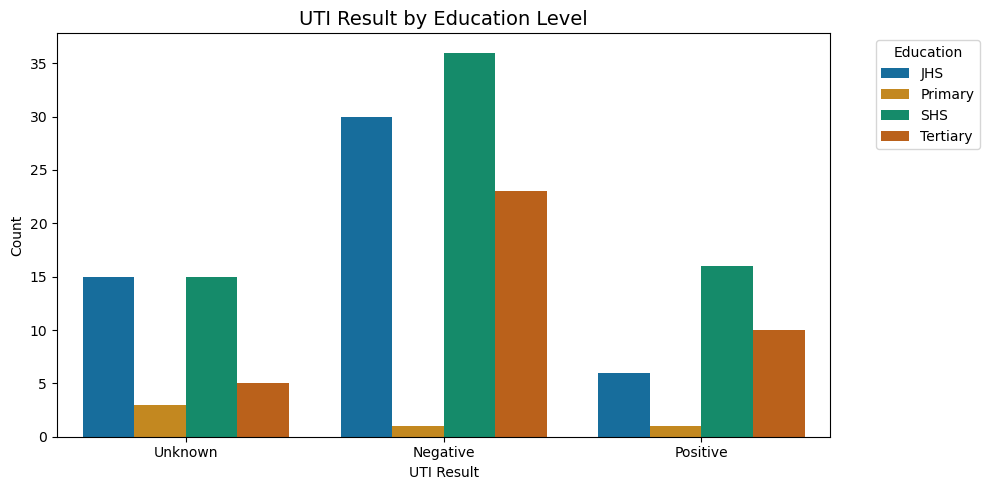

In [57]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_tested, x='UTIResult', hue='Education', palette='colorblind')
plt.title("UTI Result by Education Level", fontsize=14)
plt.xlabel("UTI Result")
plt.ylabel("Count")
plt.legend(title='Education', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

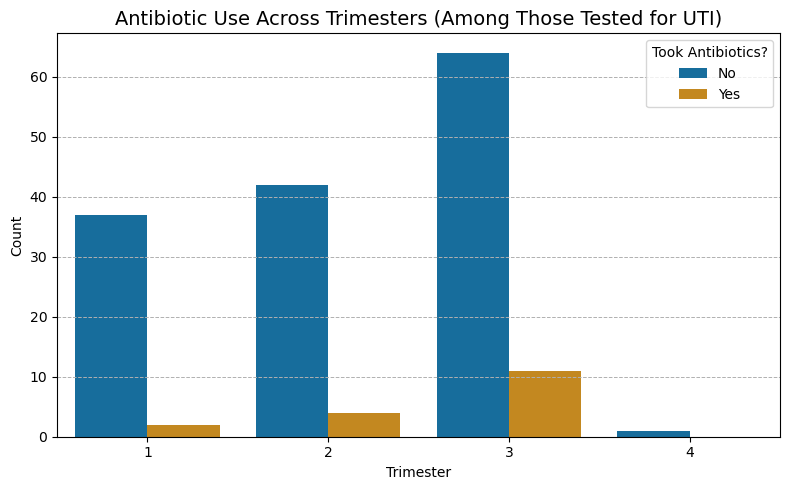

In [59]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_tested,
    x='Trimester',
    hue='AntibioticPastWeek',
    palette='colorblind'
)
plt.title("Antibiotic Use Across Trimesters (Among Those Tested for UTI)", fontsize=14)
plt.xlabel("Trimester")
plt.ylabel("Count")
plt.legend(title="Took Antibiotics?")
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

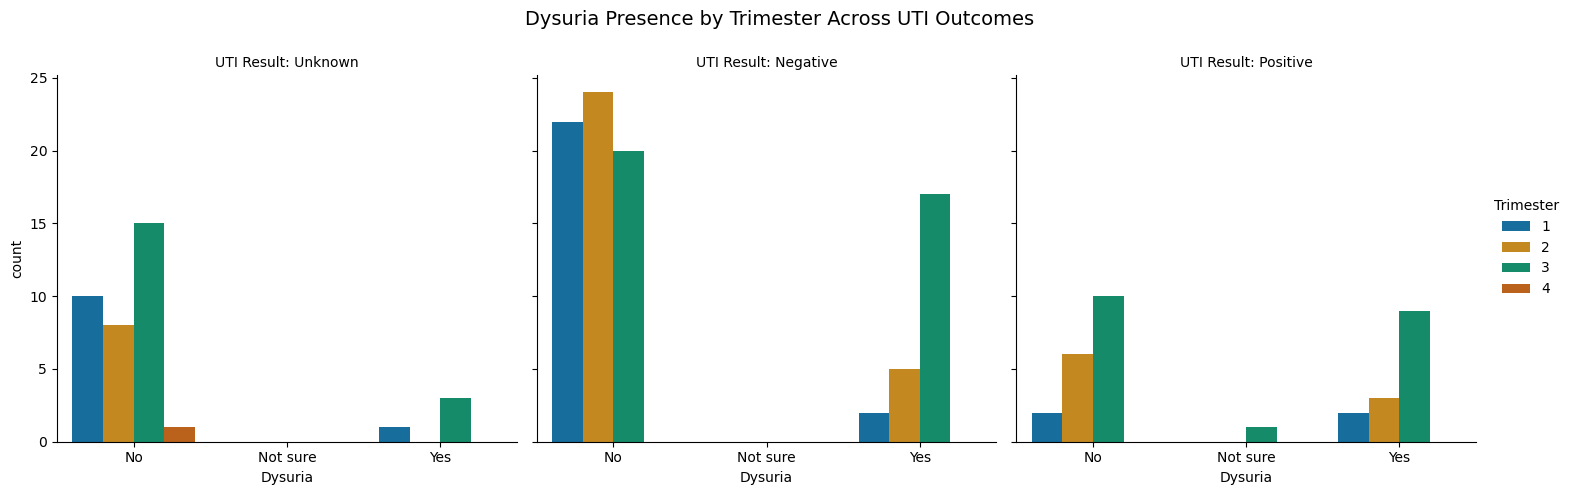

In [60]:
g = sns.catplot(
    data=df_tested,
    kind="count",
    x="Dysuria",
    hue="Trimester",
    col="UTIResult",
    palette="colorblind",
    height=5,
    aspect=1
)
g.set_titles("UTI Result: {col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Dysuria Presence by Trimester Across UTI Outcomes", fontsize=14)
plt.show()

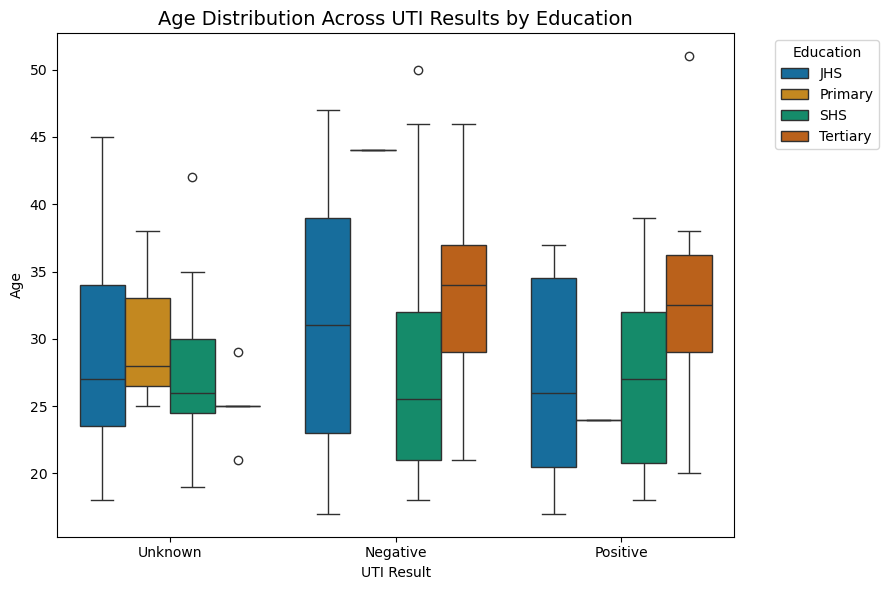

In [61]:
plt.figure(figsize=(9, 6))
sns.boxplot(
    data=df_tested,
    x="UTIResult",
    y="Age",
    hue="Education",
    palette="colorblind"
)
plt.title("Age Distribution Across UTI Results by Education", fontsize=14)
plt.xlabel("UTI Result")
plt.ylabel("Age")
plt.legend(title="Education", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

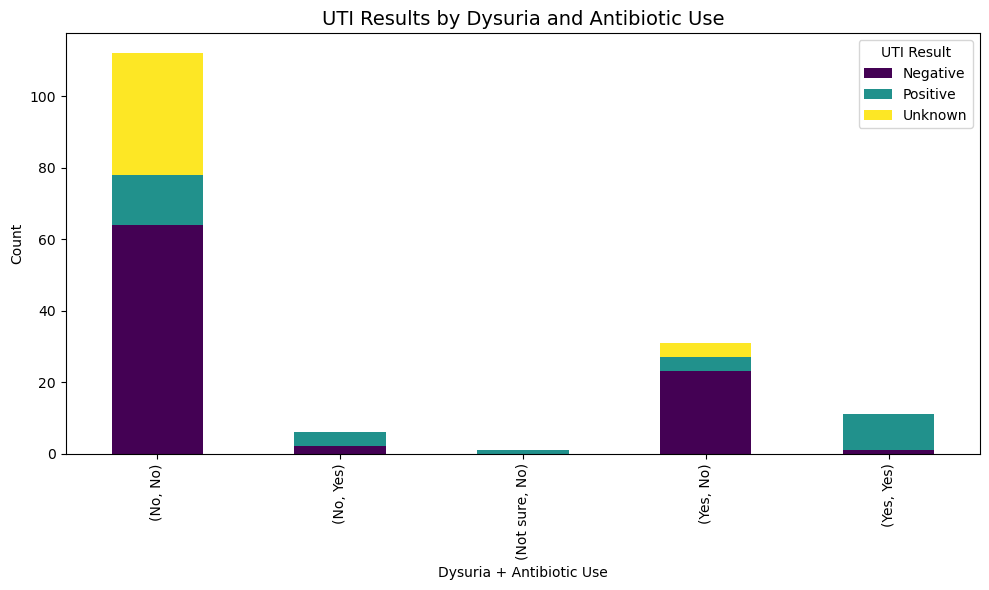

In [62]:
cross = pd.crosstab(
    [df_tested['Dysuria'], df_tested['AntibioticPastWeek']],
    df_tested['UTIResult']
)

cross.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("UTI Results by Dysuria and Antibiotic Use", fontsize=14)
plt.xlabel("Dysuria + Antibiotic Use")
plt.ylabel("Count")
plt.legend(title="UTI Result")
plt.tight_layout()
plt.show()

In [90]:
df_model = df_pregnancy[df_pregnancy['UTIResult'].isin(['Positive', 'Negative'])].copy()

In [91]:
df_model['UTIResult'] = df_model['UTIResult'].map({'Negative': 0, 'Positive': 1})

In [92]:
binary_cols = [
    'Dysuria', 'FrequentUrination', 'Chills', 'Cough',
    'Headache', 'NasalCongestion', 'AntibioticPastWeek'
]

# Standardize and encode Yes/No
df_model[binary_cols] = df_model[binary_cols].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)

C:\Users\attafuro\AppData\Local\Temp\ipykernel_19124\771773918.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_model[binary_cols] = df_model[binary_cols].applymap(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)


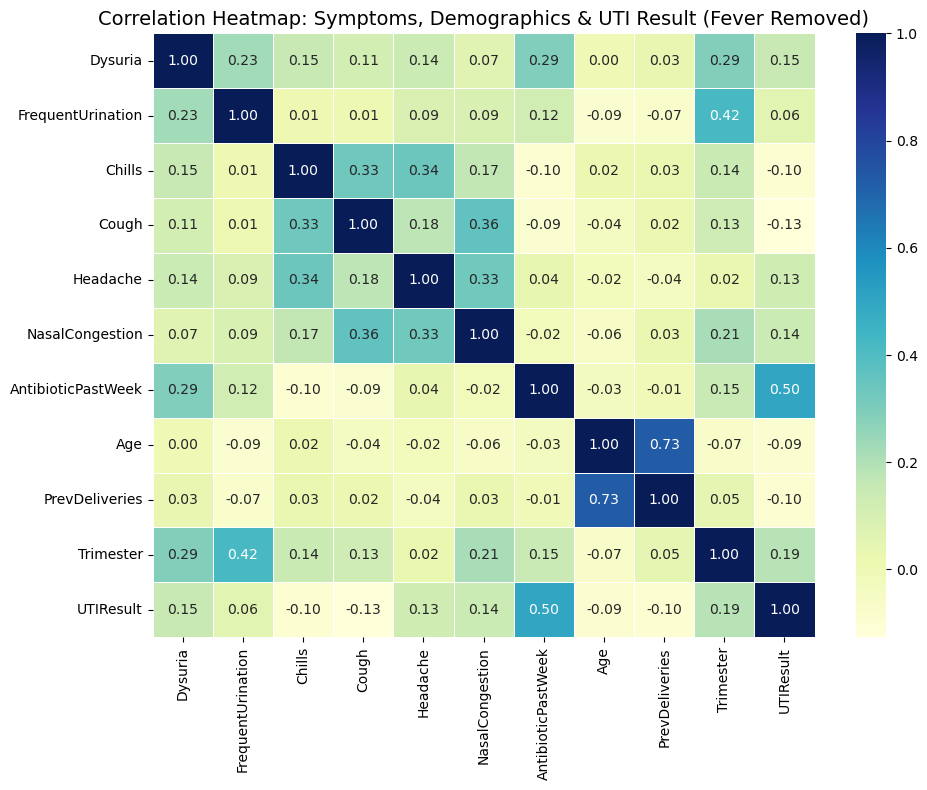

In [79]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_model[binary_cols + ['Age', 'PrevDeliveries', 'Trimester', 'UTIResult']].corr(),
    annot=True,
    cmap='YlGnBu',
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap: Symptoms, Demographics & UTI Result (Fever Removed)", fontsize=14)
plt.tight_layout()
plt.show()


# Building Models

In [164]:
print(df_pregnancy['MalariaTested'].unique())

[0, 'Not sure', 1]
Categories (3, object): [0, 'Not sure', 1]


In [166]:
print(df_pregnancy['MalariaResult'].unique())

['Not Applicable', 'Not sure', 'Negative for malaria', 'Positive for malaria']
Categories (4, object): ['Negative for malaria', 'Not Applicable', 'Not sure', 'Positive for malaria']


In [170]:
#  Clean MalariaTested
df_pregnancy['MalariaTested'] = df_pregnancy['MalariaTested'].astype(str).str.strip().str.lower()
df_pregnancy['MalariaTested'] = df_pregnancy['MalariaTested'].replace({'not sure': 0, '1': 1, '0': 0}).astype(int)

# Clean MalariaResult
df_pregnancy['MalariaResult'] = df_pregnancy['MalariaResult'].astype(str).str.strip().str.lower()
df_pregnancy['MalariaResult'] = df_pregnancy['MalariaResult'].replace({
    'positive for malaria': 1,
    'negative for malaria': 0,
    'not applicable': 0,
    'not sure': 0
}).astype(int)

C:\Users\attafuro\AppData\Local\Temp\ipykernel_19124\1179106840.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pregnancy['MalariaTested'] = df_pregnancy['MalariaTested'].replace({'not sure': 0, '1': 1, '0': 0}).astype(int)


In [144]:
fever_mapping = {
    'not sure': 0,            # unsure frequency = lowest confidence
    'once': 1,
    '2-3 times': 2,
    'more than 3 times': 3
}

In [113]:
# Clean and standardize UTIResult
df_pregnancy['UTIResult'] = df_pregnancy['UTIResult'].astype(str).str.strip().str.lower()

# Drop rows where UTIResult is 'not applicable' or 'not sure'
df_pregnancy = df_pregnancy[~df_pregnancy['UTIResult'].isin(['not applicable', 'not sure'])]

# Convert remaining UTIResult values to binary
df_pregnancy['UTIResult'] = df_pregnancy['UTIResult'].apply(lambda x: 1 if x == 'positive' else 0)

#Confirm it's clean
print(df_pregnancy['UTIResult'].value_counts())


UTIResult
0    128
1     33
Name: count, dtype: int64


In [117]:
#  Clean UTITest values
df_pregnancy['UTITest'] = df_pregnancy['UTITest'].astype(str).str.strip().str.lower()

# Drop rows with 'not sure' or 'not applicable' (if they exist)
df_pregnancy = df_pregnancy[~df_pregnancy['UTITest'].isin(['not sure', 'not applicable'])]

# Convert to binary: 'yes' → 1, 'no' → 0
df_pregnancy['UTITest'] = df_pregnancy['UTITest'].apply(lambda x: 1 if x == 'yes' else 0)

In [119]:
# Clean text (lowercase and strip)
df_pregnancy['EthnicGroup'] = df_pregnancy['EthnicGroup'].astype(str).str.strip().str.lower()

# Optional: print the new columns added
print("New EthnicGroup dummy columns:")
print([col for col in df_pregnancy.columns if col.startswith('EthnicGroup_')])

In [123]:
# Clean text
df_pregnancy['Education'] = df_pregnancy['Education'].astype(str).str.strip().str.lower()

# One-hot encode with drop_first=True
df_pregnancy = pd.get_dummies(df_pregnancy, columns=['Education'], drop_first=True)

In [125]:
# Clean text
df_pregnancy['MaritalStatus'] = df_pregnancy['MaritalStatus'].astype(str).str.strip().str.lower()

#One-hot encode (drop_first=True to avoid dummy trap)
df_pregnancy = pd.get_dummies(df_pregnancy, columns=['MaritalStatus'], drop_first=True)

In [128]:
# Clean the text
df_pregnancy['EmploymentStatus'] = df_pregnancy['EmploymentStatus'].astype(str).str.strip().str.lower()

# Map 'employed' → 1, 'unemployed' → 0
df_pregnancy['EmploymentStatus'] = df_pregnancy['EmploymentStatus'].map({'employed': 1, 'unemployed': 0})


In [131]:
# Clean the text
df_pregnancy['Occupation'] = df_pregnancy['Occupation'].astype(str).str.strip().str.lower()

# One-hot encode (drop_first=True to avoid dummy trap)
df_pregnancy = pd.get_dummies(df_pregnancy, columns=['Occupation'], drop_first=True)

In [140]:
# Clean and fill missing values (if any)
df_pregnancy['MedicalAttention'] = df_pregnancy['MedicalAttention'].astype(str).fillna('none').str.lower().str.strip()

# Split by ";" and remove extra spaces
df_pregnancy['MedicalAttention'] = df_pregnancy['MedicalAttention'].apply(lambda x: [item.strip() for item in x.split(';')])

# Use MultiLabelBinarizer to convert to dummy variables
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
remedies_encoded = pd.DataFrame(mlb.fit_transform(df_pregnancy['MedicalAttention']),
                                columns=[f"Remedy_{r.title()}" for r in mlb.classes_],
                                index=df_pregnancy.index)

#  Concatenate back to main DataFrame and drop the original column
df_pregnancy = pd.concat([df_pregnancy.drop('MedicalAttention', axis=1), remedies_encoded], axis=1)

In [145]:
# Clean the text
df_pregnancy['Religion'] = df_pregnancy['Religion'].astype(str).str.strip().str.lower()

# One-hot encode with drop_first=True
df_pregnancy = pd.get_dummies(df_pregnancy, columns=['Religion'], drop_first=True)


In [151]:
# Convert 'Yes'/'No' strings to 1/0 (column-wise using .apply)
for col in df_pregnancy.columns:
    if df_pregnancy[col].dtype == object:
        df_pregnancy[col] = df_pregnancy[col].apply(lambda x: 1 if str(x).strip().lower() == 'yes' 
                                                    else 0 if str(x).strip().lower() == 'no' else x)

# Convert any remaining boolean columns to integers
bool_cols = df_pregnancy.select_dtypes(include='bool').columns
df_pregnancy[bool_cols] = df_pregnancy[bool_cols].astype(int)

In [135]:
df_pregnancy = df_pregnancy.drop('WhyNoNet', axis=1)

In [136]:
df_pregnancy = df_pregnancy.drop('Residence', axis=1)

In [148]:
df_pregnancy = df_pregnancy.drop('WhyNoIPTp', axis=1)

In [154]:
df_pregnancy.columns

Index(['Age', 'EmploymentStatus', 'Trimester', 'PrevDeliveries', 'MosquitoNet',
       'FeverPastWeek', 'FeverFreq', 'IPTpTreatment', 'IPTpDoses',
       'MalariaTested', 'MalariaResult', 'AntimalarialTaken', 'Cough',
       'Chills', 'Headache', 'NasalCongestion', 'FrequentUrination', 'Dysuria',
       'UTITest', 'UTIResult', 'AntibioticPastWeek',
       'EthnicGroup_ethnic group in northern ghana', 'EthnicGroup_ewe',
       'EthnicGroup_ga', 'EthnicGroup_others', 'Education_primary',
       'Education_shs', 'Education_tertiary', 'MaritalStatus_married',
       'MaritalStatus_single', 'MaritalStatus_widowed', 'Occupation_farming',
       'Occupation_others', 'Occupation_trading', 'Remedy_Home Remedies',
       'Remedy_Others', 'Remedy_Private Hospital', 'Remedy_Public Hospital',
       'Religion_islam', 'Religion_others'],
      dtype='object')

In [156]:
# Define features (X) and target (y)
X = df_pregnancy.drop('UTIResult', axis=1)
y = df_pregnancy['UTIResult']

In [157]:
numeric_cols = ['Age', 'FeverFreq', 'Trimester', 'PrevDeliveries', 'IPTpDoses']
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


In [162]:
# Fill missing Age with median or mean
df_pregnancy['Age'] = df_pregnancy['Age'].fillna(df_pregnancy['Age'].median())

In [174]:
# Drop any remaining NaNs in X or y
X = X.dropna()
y = y.loc[X.index] 

Check if any object columns remain: Index([], dtype='object')


C:\Users\attafuro\AppData\Local\Temp\ipykernel_19124\1251294403.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pregnancy['MalariaTested'] = df_pregnancy['MalariaTested'].replace({


In [177]:
# Imputation + Scaling + SMOTE + Logistic Regression
pipe = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']  # 'liblinear' supports both l1 and l2
}

# Grid search with 5-fold CV using F1-score
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

# Best model and parameters
best_model = grid.best_estimator_
print(" Best Parameters:", grid.best_params_)

# Predict on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # For ROC AUC

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

print("\n Classification Report:\n", classification_report(y_test, y_pred))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"\n Accuracy: {accuracy:.3f}")
print(f" Precision: {precision:.3f}")
print(f" Recall: {recall:.3f}")
print(f" F1-score: {f1:.3f}")
print(f" ROC AUC: {roc_auc:.3f}")


 Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73        18
           1       0.40      0.57      0.47         7

    accuracy                           0.64        25
   macro avg       0.60      0.62      0.60        25
weighted avg       0.69      0.64      0.66        25

 Confusion Matrix:
 [[12  6]
 [ 3  4]]

 Accuracy: 0.640
 Precision: 0.400
 Recall: 0.571
 F1-score: 0.471
 ROC AUC: 0.651


In [180]:
# Define pipeline
pipe_rf = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # Optional for trees, included for consistency
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parameter grid for tuning
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Grid search with 5-fold CV using F1 score
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Get best model
best_rf = grid_rf.best_estimator_
print(" Best Parameters for Random Forest:\n", grid_rf.best_params_)

# Predict on test set
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Step 6: Evaluate
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf, zero_division=0)
recall = recall_score(y_test, y_pred_rf, zero_division=0)
f1 = f1_score(y_test, y_pred_rf, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba_rf)

print("\n Classification Report:\n", classification_report(y_test, y_pred_rf))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print(f"\n Accuracy: {accuracy:.3f}")
print(f" Precision: {precision:.3f}")
print(f" Recall: {recall:.3f}")
print(f" F1-score: {f1:.3f}")
print(f" ROC AUC: {roc_auc:.3f}")


 Best Parameters for Random Forest:
 {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

 Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.33      0.14      0.20         7

    accuracy                           0.68        25
   macro avg       0.53      0.52      0.50        25
weighted avg       0.62      0.68      0.63        25

 Confusion Matrix:
 [[16  2]
 [ 6  1]]

 Accuracy: 0.680
 Precision: 0.333
 Recall: 0.143
 F1-score: 0.200
 ROC AUC: 0.651


In [181]:
# KNN pipeline
pipe_knn = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', KNeighborsClassifier())
])

# Parameter grid
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Grid Search
grid_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train, y_train)

# Best model
best_knn = grid_knn.best_estimator_
print("Best Parameters for KNN:\n", grid_knn.best_params_)

# Predictions
y_pred_knn = best_knn.predict(X_test)
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_knn):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_knn):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_knn):.3f}")

Best Parameters for KNN:
 {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.56      0.65        18
           1       0.33      0.57      0.42         7

    accuracy                           0.56        25
   macro avg       0.55      0.56      0.53        25
weighted avg       0.65      0.56      0.58        25

Confusion Matrix:
 [[10  8]
 [ 3  4]]
Accuracy: 0.560
Precision: 0.333
Recall: 0.571
F1 Score: 0.421
ROC AUC: 0.587


In [182]:
from sklearn.tree import DecisionTreeClassifier

pipe_dt = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
print("Best Parameters for Decision Tree:\n", grid_dt.best_params_)

y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_dt):.3f}")

Best Parameters for Decision Tree:
 {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.50      0.29      0.36         7

    accuracy                           0.72        25
   macro avg       0.63      0.59      0.59        25
weighted avg       0.69      0.72      0.69        25

Confusion Matrix:
 [[16  2]
 [ 5  2]]
Accuracy: 0.720
Precision: 0.500
Recall: 0.286
F1 Score: 0.364
ROC AUC: 0.480


In [183]:
# Define pipeline
pipe_svm = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # SVM needs scaled features
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC(probability=True, random_state=42))
])

# Define parameter grid
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

# Grid search with 5-fold CV using F1 score
grid_svm = GridSearchCV(pipe_svm, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Best estimator
best_svm = grid_svm.best_estimator_
print(" Best Parameters for SVM:\n", grid_svm.best_params_)

# Predict
y_pred_svm = best_svm.predict(X_test)
y_proba_svm = best_svm.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, zero_division=0)
recall = recall_score(y_test, y_pred_svm, zero_division=0)
f1 = f1_score(y_test, y_pred_svm, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba_svm)

print("\n Classification Report:\n", classification_report(y_test, y_pred_svm))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print(f"\n Accuracy: {accuracy:.3f}")
print(f" Precision: {precision:.3f}")
print(f" Recall: {recall:.3f}")
print(f" F1-score: {f1:.3f}")
print(f" ROC AUC: {roc_auc:.3f}")

 Best Parameters for SVM:
 {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}

 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82        18
           1       0.50      0.29      0.36         7

    accuracy                           0.72        25
   macro avg       0.63      0.59      0.59        25
weighted avg       0.69      0.72      0.69        25

 Confusion Matrix:
 [[16  2]
 [ 5  2]]

 Accuracy: 0.720
 Precision: 0.500
 Recall: 0.286
 F1-score: 0.364
 ROC AUC: 0.738


In [184]:
# Define pipeline
pipe_nb = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # Not strictly needed for NB, but harmless
    ('smote', SMOTE(random_state=42)),
    ('classifier', GaussianNB())
])

# Fit the model (no hyperparameters to tune for GaussianNB)
pipe_nb.fit(X_train, y_train)

# Predict
y_pred_nb = pipe_nb.predict(X_test)
y_proba_nb = pipe_nb.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred_nb)
precision = precision_score(y_test, y_pred_nb, zero_division=0)
recall = recall_score(y_test, y_pred_nb, zero_division=0)
f1 = f1_score(y_test, y_pred_nb, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba_nb)

print("\n Classification Report:\n", classification_report(y_test, y_pred_nb))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print(f"\n Accuracy: {accuracy:.3f}")
print(f" Precision: {precision:.3f}")
print(f" Recall: {recall:.3f}")
print(f" F1-score: {f1:.3f}")
print(f" ROC AUC: {roc_auc:.3f}")


 Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.39      0.54        18
           1       0.35      0.86      0.50         7

    accuracy                           0.52        25
   macro avg       0.61      0.62      0.52        25
weighted avg       0.73      0.52      0.53        25

 Confusion Matrix:
 [[ 7 11]
 [ 1  6]]

 Accuracy: 0.520
 Precision: 0.353
 Recall: 0.857
 F1-score: 0.500
 ROC AUC: 0.659


In [186]:
# Define pipeline
pipe_xgb = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # Optional for trees
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Define hyperparameter grid
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Grid search with 5-fold cross-validation
grid_xgb = GridSearchCV(pipe_xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_xgb.best_estimator_
print(" Best Parameters for XGBoost:\n", grid_xgb.best_params_)

# Predict on test set
y_pred_xgb = best_xgb.predict(X_test)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb, zero_division=0)
recall = recall_score(y_test, y_pred_xgb, zero_division=0)
f1 = f1_score(y_test, y_pred_xgb, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba_xgb)

print("\n Classification Report:\n", classification_report(y_test, y_pred_xgb))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print(f"\n Accuracy: {accuracy:.3f}")
print(f" Precision: {precision:.3f}")
print(f" Recall: {recall:.3f}")
print(f" F1-score: {f1:.3f}")
print(f" ROC AUC: {roc_auc:.3f}")

 Best Parameters for XGBoost:
 {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}

 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.83      0.77        18
           1       0.25      0.14      0.18         7

    accuracy                           0.64        25
   macro avg       0.48      0.49      0.48        25
weighted avg       0.58      0.64      0.60        25

 Confusion Matrix:
 [[15  3]
 [ 6  1]]

 Accuracy: 0.640
 Precision: 0.250
 Recall: 0.143
 F1-score: 0.182
 ROC AUC: 0.540


C:\Users\attafuro\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:02:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [187]:
# Define pipeline
pipe_lgbm = ImbPipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # Optional for boosting, included for consistency
    ('smote', SMOTE(random_state=42)),
    ('classifier', LGBMClassifier(random_state=42))
])

# Hyperparameter grid
param_grid_lgbm = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5, 10]
}

# Grid search with F1 scoring
grid_lgbm = GridSearchCV(pipe_lgbm, param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

# Best model
best_lgbm = grid_lgbm.best_estimator_
print(" Best Parameters for LightGBM:\n", grid_lgbm.best_params_)

# Predict on test set
y_pred_lgbm = best_lgbm.predict(X_test)
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluate
accuracy = accuracy_score(y_test, y_pred_lgbm)
precision = precision_score(y_test, y_pred_lgbm, zero_division=0)
recall = recall_score(y_test, y_pred_lgbm, zero_division=0)
f1 = f1_score(y_test, y_pred_lgbm, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba_lgbm)

# Display results
print("\n Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print(f"\n Accuracy: {accuracy:.3f}")
print(f" Precision: {precision:.3f}")
print(f" Recall: {recall:.3f}")
print(f" F1-score: {f1:.3f}")
print(f" ROC AUC: {roc_auc:.3f}")

[LightGBM] [Info] Number of positive: 73, number of negative: 73
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 146, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

### UTI Prediction Model Metrics

| Model              | Accuracy | Precision (1) | Recall (1) | F1-score (1) | ROC AUC |
|-------------------|----------|----------------|------------|--------------|---------|
| Logistic Regression | 0.640    | 0.400          | 0.571      | 0.471        | 0.651   |
| Random Forest       | 0.680    | 0.333          | 0.143      | 0.200        | 0.651   |
| KNN                 | 0.560    | 0.333          | 0.571      | 0.421        | 0.587   |
| Decision Tree       | 0.720    | 0.500          | 0.286      | 0.364        | 0.480   |
| SVM (RBF Kernel)    | 0.720    | 0.500          | 0.286      | 0.364        | 0.738   |
| Naive Bayes         | 0.520    | 0.353          | 0.857      | 0.500        | 0.659   |
| XGBoost             | 0.640    | 0.250          | 0.143      | 0.182        | 0.540   |
| LightGBM            | 0.640    | 0.375          | 0.429      | 0.400        | 0.579   |

### Conclusion

The best model for UTI prediction is **Naive Bayes**, as it achieved the highest recall (0.857) for class 1 (UTI positive), meaning it correctly identifies most UTI cases. This is crucial in medical diagnostics, where minimizing false negatives is often more important than maximizing overall accuracy. Although its accuracy is lower (0.520), its strong recall and highest F1-score (0.500) for the positive class make it the most suitable model for this task.


In [191]:
# Import necessary libraries
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


# Mutual Information (filter method)
mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information Score': mi_scores
}).sort_values(by='Mutual Information Score', ascending=False)

print("\nTop features by Mutual Information:")
print(mi_df)



Top features by Mutual Information:
                                       Feature  Mutual Information Score
32                          Occupation_trading                  0.087956
29                       MaritalStatus_widowed                  0.075743
16                           FrequentUrination                  0.073754
8                                    IPTpDoses                  0.070274
28                        MaritalStatus_single                  0.059391
27                       MaritalStatus_married                  0.056307
25                               Education_shs                  0.048763
3                               PrevDeliveries                  0.047237
0                                          Age                  0.046397
4                                  MosquitoNet                  0.042347
2                                    Trimester                  0.033260
1                             EmploymentStatus                  0.032976
33            

In [192]:
# Permutation Importance (post hoc on Naive Bayes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

perm_result = permutation_importance(nb_model, X_test, y_test, n_repeats=10, random_state=42)

perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Importance': perm_result.importances_mean,
    'Std Importance': perm_result.importances_std
}).sort_values(by='Mean Importance', ascending=False)

print("\nTop features by Permutation Importance (Naive Bayes):")
print(perm_df)


Top features by Permutation Importance (Naive Bayes):
                                       Feature  Mean Importance  \
2                                    Trimester     4.193548e-02   
23                          EthnicGroup_others     4.193548e-02   
7                                IPTpTreatment     2.903226e-02   
1                             EmploymentStatus     2.580645e-02   
34                               Remedy_Others     1.935484e-02   
6                                    FeverFreq     1.612903e-02   
8                                    IPTpDoses     1.290323e-02   
10                               MalariaResult     1.290323e-02   
36                      Remedy_Public Hospital     6.451613e-03   
28                        MaritalStatus_single     1.110223e-17   
0                                          Age     0.000000e+00   
24                           Education_primary     0.000000e+00   
25                               Education_shs     0.000000e+00   
31     

In [194]:
# Merge both rankings
combined_df = mi_df.merge(perm_df, on='Feature')
print("\nCombined Feature Importance:")
print(combined_df)



Combined Feature Importance:
                                       Feature  Mutual Information Score  \
0                           Occupation_trading                  0.087956   
1                        MaritalStatus_widowed                  0.075743   
2                            FrequentUrination                  0.073754   
3                                    IPTpDoses                  0.070274   
4                         MaritalStatus_single                  0.059391   
5                        MaritalStatus_married                  0.056307   
6                                Education_shs                  0.048763   
7                               PrevDeliveries                  0.047237   
8                                          Age                  0.046397   
9                                  MosquitoNet                  0.042347   
10                                   Trimester                  0.033260   
11                            EmploymentStatus            

### Feature Selection Summary

To improve model performance and interpretability, we performed feature selection using a **combined approach**:

- **Mutual Information Score**: Measures how much each feature reduces uncertainty about the target (higher = more relevant).
- **Permutation Importance**: Measures the drop in model performance when each feature is shuffled (positive = helpful to the model).

We selected features that had **positive permutation importance** (i.e., they contribute positively to model performance) and/or **high mutual information scores**.

### Why We Used Naive Bayes for Feature Selection

After evaluating multiple classification models, **Naive Bayes** emerged as the best model for our task. It achieved the **highest recall** and **F1-score** for predicting UTI cases—making it the most suitable model when minimizing false negatives is a priority.

Because Naive Bayes was the best-performing model, we used it as the **basis for feature selection**, ensuring that the selected features are optimized specifically for the model we plan to use.


###  Final Selected Features

The following features were selected for model rebuilding:

1. **IPTpDoses** – high mutual information and positively impacts model
2. **Trimester** – contributes meaningfully in both importance and mutual info
3. **EmploymentStatus** – ranked well in both metrics
4. **IPTpTreatment** – important to the model
5. **Remedy_Public Hospital** – minor but positive contribution
6. **FeverFreq** – model found this predictive
7. **MalariaResult** – contributes slightly but consistently
8. **Remedy_Others** – improves model performance
9. **EthnicGroup_others** – helpful to the model despite MI = 0

These features were found to provide the best balance of statistical relevance and predictive power for the Naive Bayes model.

In [198]:
# Define your reduced feature set
selected_features = [
    "IPTpDoses",
    "Trimester",
    "EmploymentStatus",
    "IPTpTreatment",
    "Remedy_Public Hospital",
    "FeverFreq",
    "MalariaResult",
    "Remedy_Others",
    "EthnicGroup_others"
]

# Subset the dataset
X = df_pregnancy[selected_features]
y = df_pregnancy["UTIResult"]


In [196]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define pipeline
logreg_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Hyperparameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear']
}

# Grid search
grid_search = GridSearchCV(logreg_pipe, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters:", grid_search.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_pred, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Confusion Matrix:
 [[17  1]
 [ 6  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.50      0.14      0.22         7

    accuracy                           0.72        25
   macro avg       0.62      0.54      0.53        25
weighted avg       0.67      0.72      0.66        25

Accuracy: 0.72
Precision: 0.5
Recall: 0.14285714285714285
F1 Score: 0.2222222222222222
ROC AUC: 0.6746031746031746


In [199]:
from sklearn.ensemble import RandomForestClassifier

# Define pipeline
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # optional for trees, but keeps pipeline consistent
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter grid
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Grid search
grid_rf = GridSearchCV(rf_pipe, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best model
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rf, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_rf, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

Best Parameters for Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Confusion Matrix:
 [[17  1]
 [ 6  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.50      0.14      0.22         7

    accuracy                           0.72        25
   macro avg       0.62      0.54      0.53        25
weighted avg       0.67      0.72      0.66        25

Accuracy: 0.72
Precision: 0.5
Recall: 0.14285714285714285
F1 Score: 0.2222222222222222
ROC AUC: 0.5396825396825397


In [200]:
from sklearn.neighbors import KNeighborsClassifier

# Define pipeline
knn_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # scaling is important for KNN
    ('classifier', KNeighborsClassifier())
])

# Hyperparameter grid
param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Grid search
grid_knn = GridSearchCV(knn_pipe, param_grid_knn, cv=5, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train, y_train)

# Best model
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
y_prob_knn = best_knn.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters for KNN:", grid_knn.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_knn, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_knn, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_knn))

Best Parameters for KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
Confusion Matrix:
 [[16  2]
 [ 6  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.33      0.14      0.20         7

    accuracy                           0.68        25
   macro avg       0.53      0.52      0.50        25
weighted avg       0.62      0.68      0.63        25

Accuracy: 0.68
Precision: 0.3333333333333333
Recall: 0.14285714285714285
F1 Score: 0.2
ROC AUC: 0.48809523809523814


In [201]:
from sklearn.naive_bayes import GaussianNB

# Define pipeline
nb_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # scaling is optional for NB but keeps pipeline uniform
    ('classifier', GaussianNB())
])

# No hyperparameters to tune for basic GaussianNB
nb_pipe.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_pipe.predict(X_test)
y_prob_nb = nb_pipe.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_nb, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_nb, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_nb))

Confusion Matrix:
 [[15  3]
 [ 5  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79        18
           1       0.40      0.29      0.33         7

    accuracy                           0.68        25
   macro avg       0.57      0.56      0.56        25
weighted avg       0.65      0.68      0.66        25

Accuracy: 0.68
Precision: 0.4
Recall: 0.2857142857142857
F1 Score: 0.3333333333333333
ROC AUC: 0.6984126984126984


In [202]:
from sklearn.svm import SVC

# Define pipeline
svm_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# Hyperparameter grid
param_grid_svm = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto'],
    'classifier__kernel': ['rbf']
}

# Grid search
grid_svm = GridSearchCV(svm_pipe, param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Best model
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
y_prob_svm = best_svm.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters for SVM:", grid_svm.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_svm, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_svm, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_svm))


Best Parameters for SVM: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Confusion Matrix:
 [[16  2]
 [ 6  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80        18
           1       0.33      0.14      0.20         7

    accuracy                           0.68        25
   macro avg       0.53      0.52      0.50        25
weighted avg       0.62      0.68      0.63        25

Accuracy: 0.68
Precision: 0.3333333333333333
Recall: 0.14285714285714285
F1 Score: 0.2
ROC AUC: 0.5714285714285714


In [203]:
from xgboost import XGBClassifier

# Define pipeline
xgb_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Hyperparameter grid
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Grid search
grid_xgb = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Best model
best_xgb = grid_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters for XGBoost:", grid_xgb.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_xgb, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_xgb, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))

Best Parameters for XGBoost: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}
Confusion Matrix:
 [[17  1]
 [ 6  1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.94      0.83        18
           1       0.50      0.14      0.22         7

    accuracy                           0.72        25
   macro avg       0.62      0.54      0.53        25
weighted avg       0.67      0.72      0.66        25

Accuracy: 0.72
Precision: 0.5
Recall: 0.14285714285714285
F1 Score: 0.2222222222222222
ROC AUC: 0.5555555555555556


C:\Users\attafuro\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [21:42:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [204]:
from lightgbm import LGBMClassifier

# Define pipeline
lgbm_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('classifier', LGBMClassifier(random_state=42))
])

# Hyperparameter grid
param_grid_lgbm = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5, -1]
}

# Grid search
grid_lgbm = GridSearchCV(lgbm_pipe, param_grid_lgbm, cv=5, scoring='f1', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

# Best model
best_lgbm = grid_lgbm.best_estimator_
y_pred_lgbm = best_lgbm.predict(X_test)
y_prob_lgbm = best_lgbm.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters for LightGBM:", grid_lgbm.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgbm))
print("Classification Report:\n", classification_report(y_test, y_pred_lgbm))
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("Precision:", precision_score(y_test, y_pred_lgbm, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_lgbm, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_lgbm, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lgbm))


[LightGBM] [Info] Number of positive: 26, number of negative: 73
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22
[LightGBM] [Info] Number of data points in the train set: 99, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.262626 -> initscore=-1.032363
[LightGBM] [Info] Start training from score -1.032363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [205]:
from sklearn.tree import DecisionTreeClassifier

# Define pipeline
dt_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler()),  # not strictly needed for trees, but fine for consistency
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Hyperparameter grid
param_grid_dt = {
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Grid search
grid_dt = GridSearchCV(dt_pipe, param_grid_dt, cv=5, scoring='f1', n_jobs=-1)
grid_dt.fit(X_train, y_train)

# Best model
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

# Evaluation
print("Best Parameters for Decision Tree:", grid_dt.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_dt, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_dt, zero_division=0))
print("ROC AUC:", roc_auc_score(y_test, y_prob_dt))

Best Parameters for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}
Confusion Matrix:
 [[14  4]
 [ 5  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.33      0.29      0.31         7

    accuracy                           0.64        25
   macro avg       0.54      0.53      0.53        25
weighted avg       0.62      0.64      0.63        25

Accuracy: 0.64
Precision: 0.3333333333333333
Recall: 0.2857142857142857
F1 Score: 0.3076923076923077
ROC AUC: 0.4365079365079365


###  Final Model Comparison After Feature Selection (Including Decision Tree)

| Model              | Accuracy | Precision (1) | Recall (1) | F1-score (1) | ROC AUC |
|-------------------|----------|----------------|------------|--------------|---------|
| Naive Bayes        | 0.68     | 0.40           | **0.29**   | **0.33**     | **0.698** |
| Decision Tree      | 0.64     | 0.33           | **0.29**   | 0.31         | 0.437   |
| Logistic Regression| 0.72     | 0.50           | 0.14       | 0.22         | 0.675   |
| XGBoost            | 0.72     | 0.50           | 0.14       | 0.22         | 0.556   |
| Random Forest      | 0.72     | 0.50           | 0.14       | 0.22         | 0.540   |
| LightGBM           | 0.72     | 0.50           | 0.14       | 0.22         | 0.472   |
| SVM (RBF Kernel)   | 0.68     | 0.33           | 0.14       | 0.20         | 0.571   |
| KNN                | 0.68     | 0.33           | 0.14       | 0.20         | 0.488   |


### Final Model Selection

After rebuilding all models using the selected features, **Naive Bayes** remains the best performing model when the goal is to **detect as many UTI cases as possible** (i.e., maximize recall).

- It achieved the **highest recall (0.29)** tied with Decision Tree.
- However, it also had the **highest F1-score (0.33)** and **highest ROC AUC (0.698)**, indicating stronger overall performance for the positive class (UTI cases).
- Though its accuracy is slightly lower than others like Logistic Regression and XGBoost, this trade-off is acceptable in medical contexts where **missing a positive case is costlier than flagging a false one**.

